# Sleep EDF Prototype Analysis

In [17]:
import os
import pickle
import json
from random import sample
from tqdm.auto import tqdm
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import torch
import torch.nn.functional as F

import librosa
import librosa.display

from yasa import sw_detect, spindles_detect

from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score
)

In [3]:
from sesm import get_data
from trainer import PLModel

## Load data and model

In [10]:
CLASS_DICT = {
    0: "W",
    1: "N1",
    2: "N2",
    3: "N3",
    4: "REM"
}

In [4]:
config = json.load(open("configs/sleep_edf.json", "r"))

In [ ]:
train_loader, val_loader, test_loader, class_weights, max_len = get_data(
    config["dataset"], config["batch_size"]
)
config.update({"class_weights": class_weights, "max_len": max_len})

In [5]:
plmodel = PLModel(stage=2, **config)
plmodel.model.load_state_dict(torch.load("models/trained_model.pt"))

<All keys matched successfully>

In [6]:
model = plmodel.model
model.eval()
model.training

False

## Calculate accuracy on test dataset

In [7]:
x_orig = []
y_pred = []
y_true = []
selective_actions_list = []
relevance_weights_list = []
predicted_head = []

for x, y in tqdm(test_loader):
    x, y = x, y
    batch_size = x.shape[0]
    y_hat_, _, selective_actions, relevance_weights = model(x, x != 0, ignore_relevance_weights=True) 
    
    y_hat_ = y_hat_.detach().reshape(batch_size, config['n_heads'], -1).cpu()
    selective_actions = selective_actions.detach().cpu()
    relevance_weights = relevance_weights.detach().cpu() 
    x = x.detach().cpu()
    y = y.detach().cpu()

    y_hat = (y_hat_ * relevance_weights.unsqueeze(-1)).sum(1)

    x_orig.append(np.concatenate(x.numpy()))
    y_pred.append(y_hat.argmax(1).numpy())
    y_true.append(y.numpy())
    selective_actions_list.append(selective_actions.numpy())
    relevance_weights_list.append(relevance_weights.numpy())
    predicted_head.append(F.softmax(y_hat_, -1).numpy())
    del x, y, y_hat, _, selective_actions, relevance_weights
    
x_orig = np.concatenate(x_orig)
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
selective_actions = np.concatenate(selective_actions_list)
relevance_weights = np.concatenate(relevance_weights_list)
predicted_head = np.concatenate(predicted_head)

  0%|          | 0/128 [00:00<?, ?it/s]

/Users/brenton/miniconda3/envs/EEG-SESM/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484612588/work/aten/src/ATen/native/Convolution.cpp:883.)
  return F.conv1d(input, weight, bias, self.stride,


In [8]:
(
    accuracy_score(y_true, y_pred),
    precision_score(y_true, y_pred, average="macro"),
    recall_score(y_true, y_pred, average="macro"),
)

(0.7728613569321534, 0.7274687885935504, 0.7870835862335197)

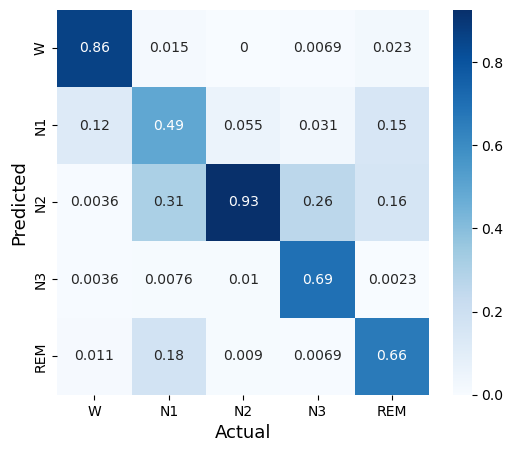

In [11]:
C = confusion_matrix(y_true, y_pred)
C = C / C.astype(float).sum(axis=0)

fig, ax = plt.subplots(figsize=(6, 5))

sns.heatmap(C, annot=True, cmap='Blues', xticklabels=CLASS_DICT.values(), yticklabels=CLASS_DICT.values())
ax.set_xlabel("Actual", fontsize=13)
ax.set_ylabel("Predicted", fontsize=13)
# plt.colorbar(cm_)
plt.show()

In [139]:
# Save the results for later use
os.makedirs('test_outputs', exist_ok=True)

with open('test_outputs/sleep_edf_x_orig_test.pkl','wb') as f:
    pickle.dump(x_orig, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('test_outputs/sleep_edf_y_true_test.pkl','wb') as f:
    pickle.dump(y_true, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('test_outputs/sleep_edf_y_pred_test.pkl','wb') as f:
    pickle.dump(y_pred, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('test_outputs/sleep_edf_selective_actions_test.pkl','wb') as f:
    pickle.dump(selective_actions, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('test_outputs/sleep_edf_relevance_weights_test.pkl','wb') as f:
    pickle.dump(relevance_weights, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('test_outputs/sleep_edf_predicted_head_test.pkl','wb') as f:
    pickle.dump(predicted_head, f, protocol=pickle.HIGHEST_PROTOCOL)


## Attention Visualisation

In [6]:
# Optionally load selective_actions from file 
with open('test_outputs/sleep_edf_x_orig_test.pkl','rb') as f:
    x_orig = pickle.load(f)

with open('test_outputs/sleep_edf_y_true_test.pkl','rb') as f:
    y_true = pickle.load(f)

with open('test_outputs/sleep_edf_y_pred_test.pkl','rb') as f:
    y_pred = pickle.load(f)

with open('test_outputs/sleep_edf_selective_actions_test.pkl','rb') as f:
    selective_actions = pickle.load(f)

with open('test_outputs/sleep_edf_relevance_weights_test.pkl','rb') as f:
    relevance_weights = pickle.load(f)

with open('test_outputs/sleep_edf_predicted_head_test.pkl','rb') as f:
    predicted_head = pickle.load(f)

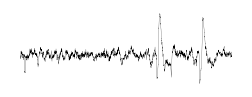

In [9]:
# Create plot for diagram
plt.plot(np.arange(max_len), x_orig[0], color='black', linewidth=0.15)
plt.gca().set_axis_off()
plt.gcf().set_size_inches(3,1)

In [16]:
selection = np.zeros((selective_actions.shape[0], selective_actions.shape[1], max_len))
for i in tqdm(range(selective_actions.shape[0])):
    for h in range(selective_actions.shape[1]):
        for k in range(selective_actions.shape[-1]):
            if selective_actions[i, h, k] > 0:
                left = max(0, k - 5)
                right = min(max_len, k + 5)
                selection[i, h, left:right] = 1

  0%|          | 0/2034 [00:00<?, ?it/s]

In [23]:
print("Printing 5 randomly sampled correct guesses from each class...\n")
for class_index in range(5):
    sampled_correct_indexes = np.random.choice(np.where((y_true == class_index) & (y_pred == class_index))[0], 5, replace=False)
    print(f"Class: {class_index}")
    print(" ".join(sampled_correct_indexes.astype(str)))
    print("\n")

Printing 5 randomly sampled correct guesses from each class...

Class: 0
2019 2016 997 2006 1002


Class: 1
90 1099 1253 1114 91


Class: 2
389 1908 665 1640 1696


Class: 3
1143 1147 1317 266 1487


Class: 4
1577 681 1958 1423 1397




### Visualise individual heads against samples

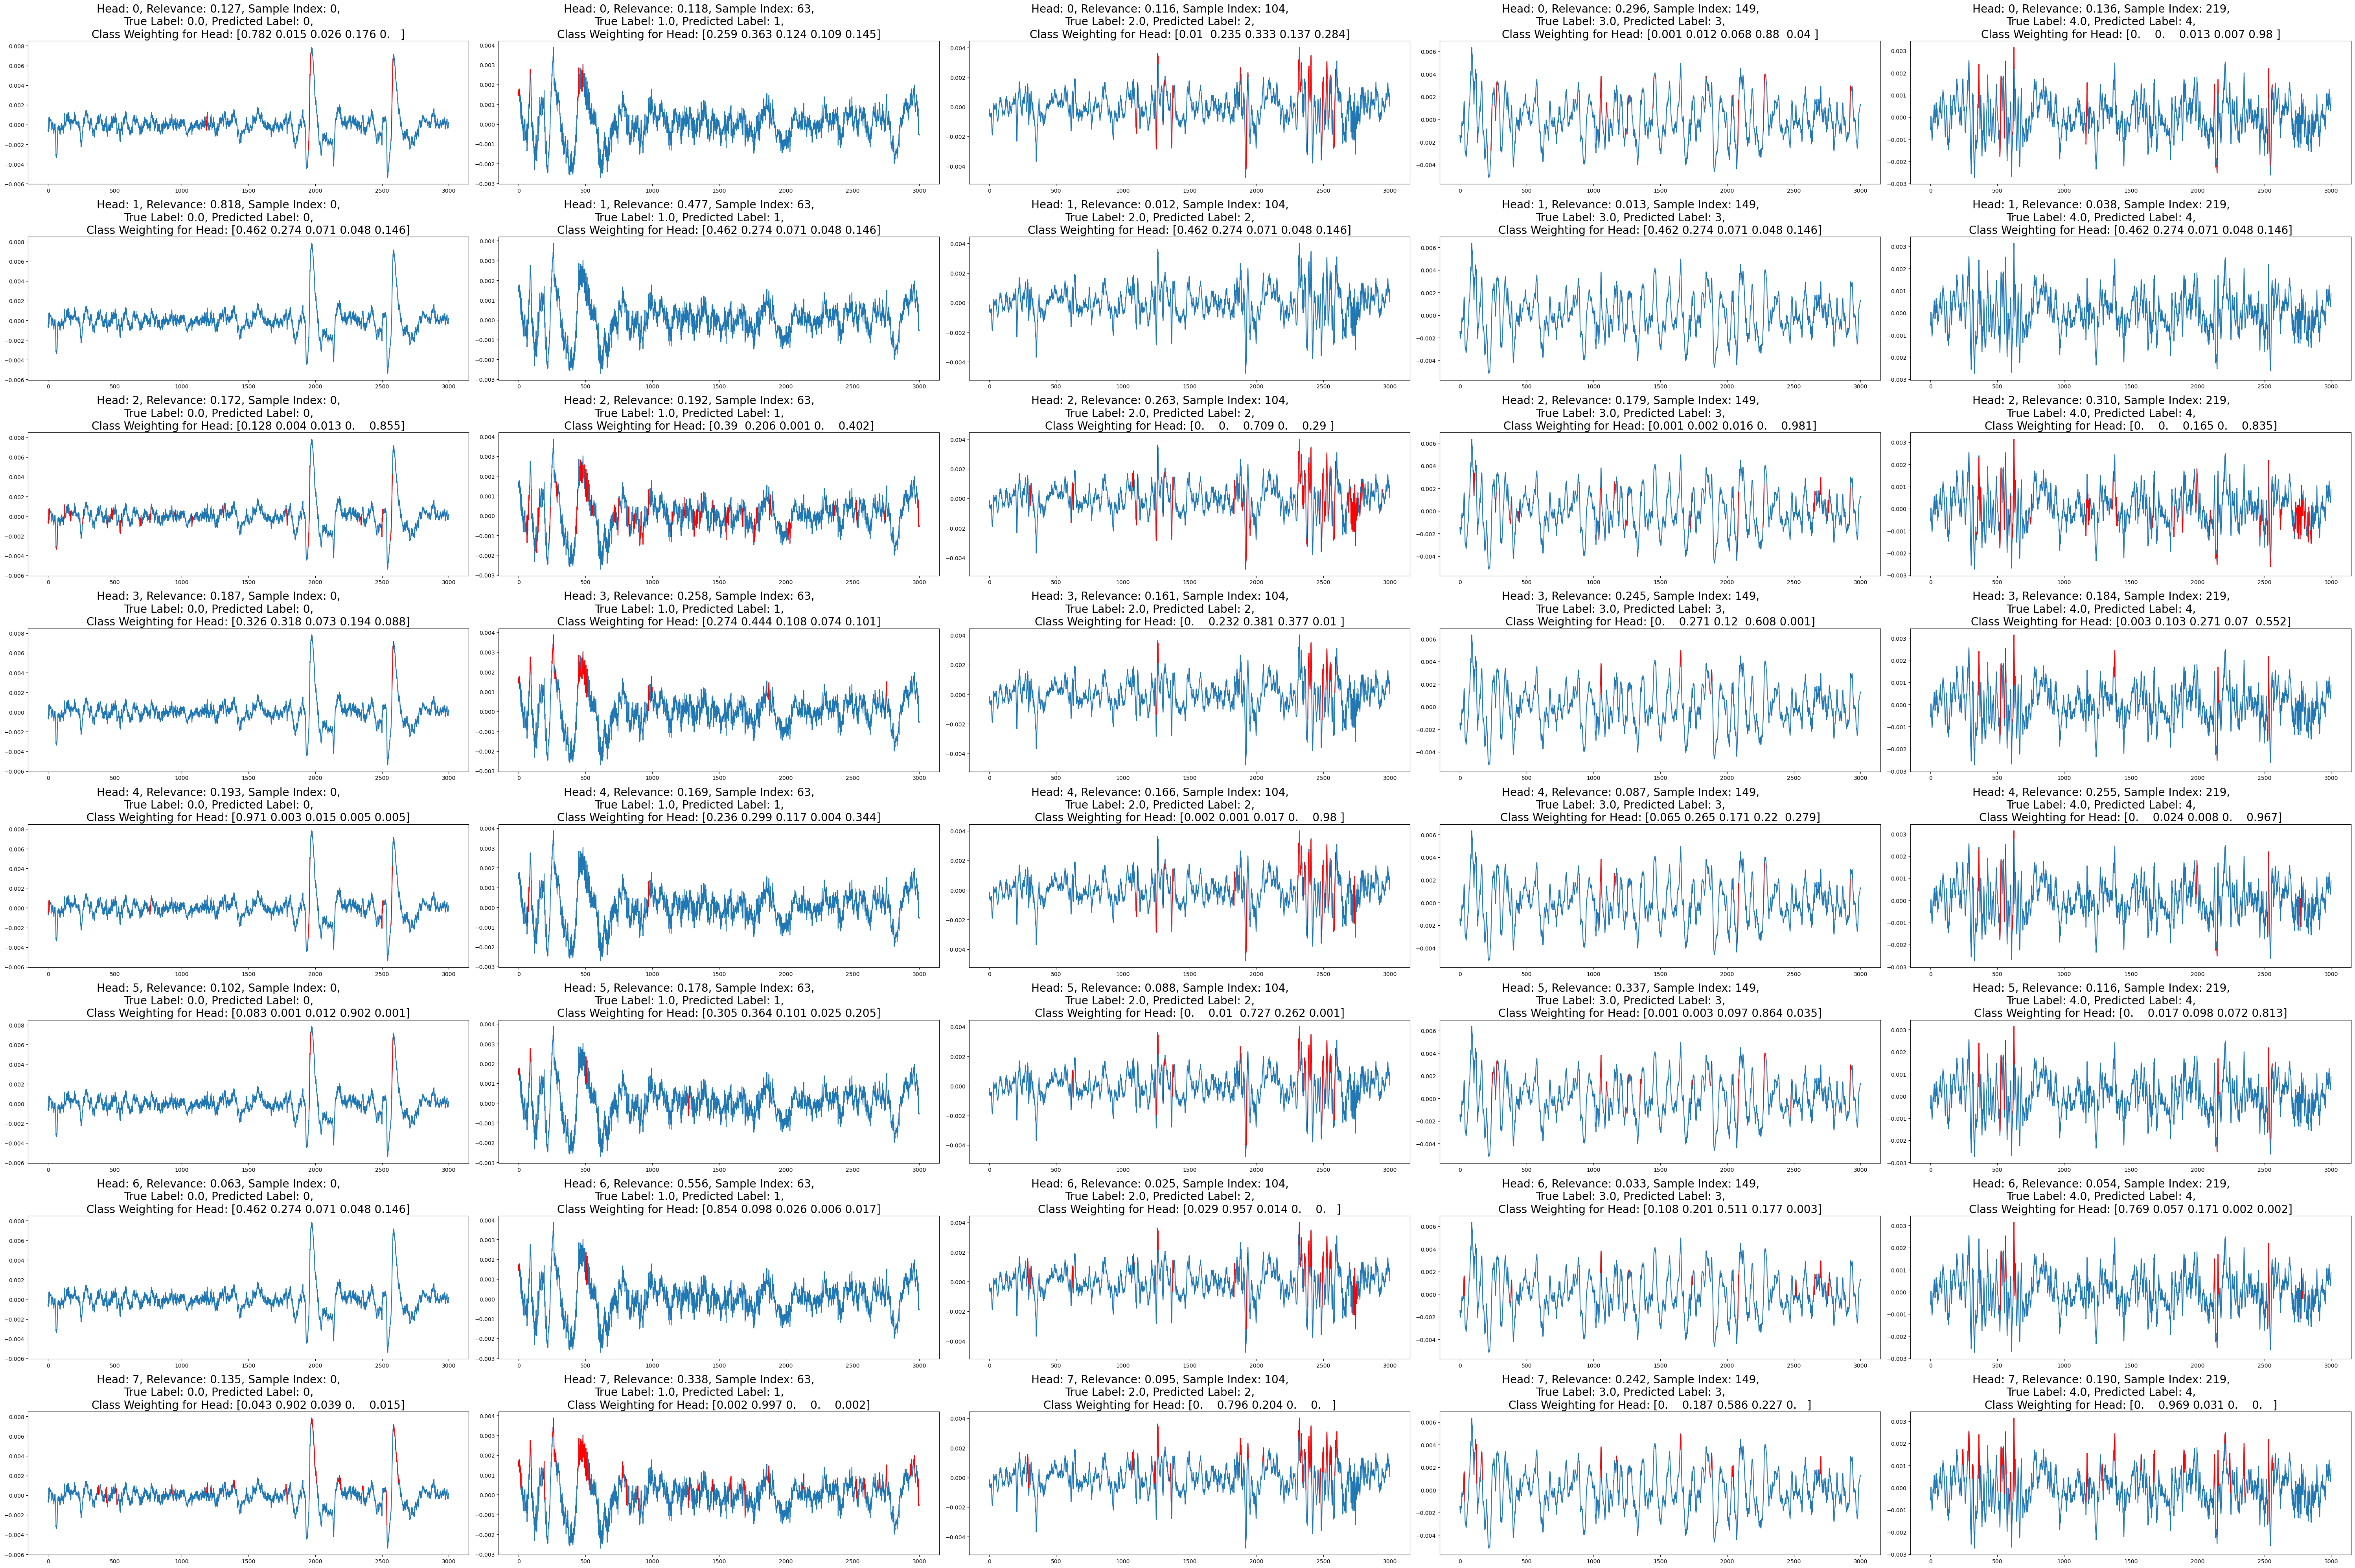

In [19]:
indices = np.array([0, 63, 104, 149, 219])

n = len(indices)
fig, ax = plt.subplots(8, 5, figsize=(60, 40))

for i in range(n):
    idx = indices[i]

    for head in range(8):

        nonzero = np.nonzero(selection[idx, head])[0]

        # Create a connect mask
        nonzero_diff = np.diff(nonzero, append=0)
        threshold = 2
        connect_mask = nonzero_diff <= threshold
        split_indices = np.where(~connect_mask)[0]
        components = np.split(nonzero, split_indices + 1)

        #sns.pointplot(x=nonzero, y=x_orig[idx, nonzero], ax=ax[head, i], hue=connect_mask, legend=False, markers='')
        
        ax[head, i].plot(np.arange(max_len), x_orig[idx])
        # Overlay non-connected line segments
        for component in components:
            ax[head, i].plot(component, x_orig[idx, component], color='r')

        # ax[head, i].title.set_text(
        #     f"{h}, {idx}, {relevance_weights[idx, head]}, {y_true[idx]}, {y_pred[idx]}"
        # )
        ax[head, i].set_title(
            f"Head: {head}, Relevance: {relevance_weights[idx][head]:0.3f}, Sample Index: {idx}, \
                \nTrue Label: {y_true[idx]}, Predicted Label: {y_pred[idx]}, \
                \nClass Weighting for Head: {np.around(predicted_head[idx, head], 3)}",
                fontsize=20
        )


plt.tight_layout()
plt.show()

### Visualise most relevant heads along side main signal

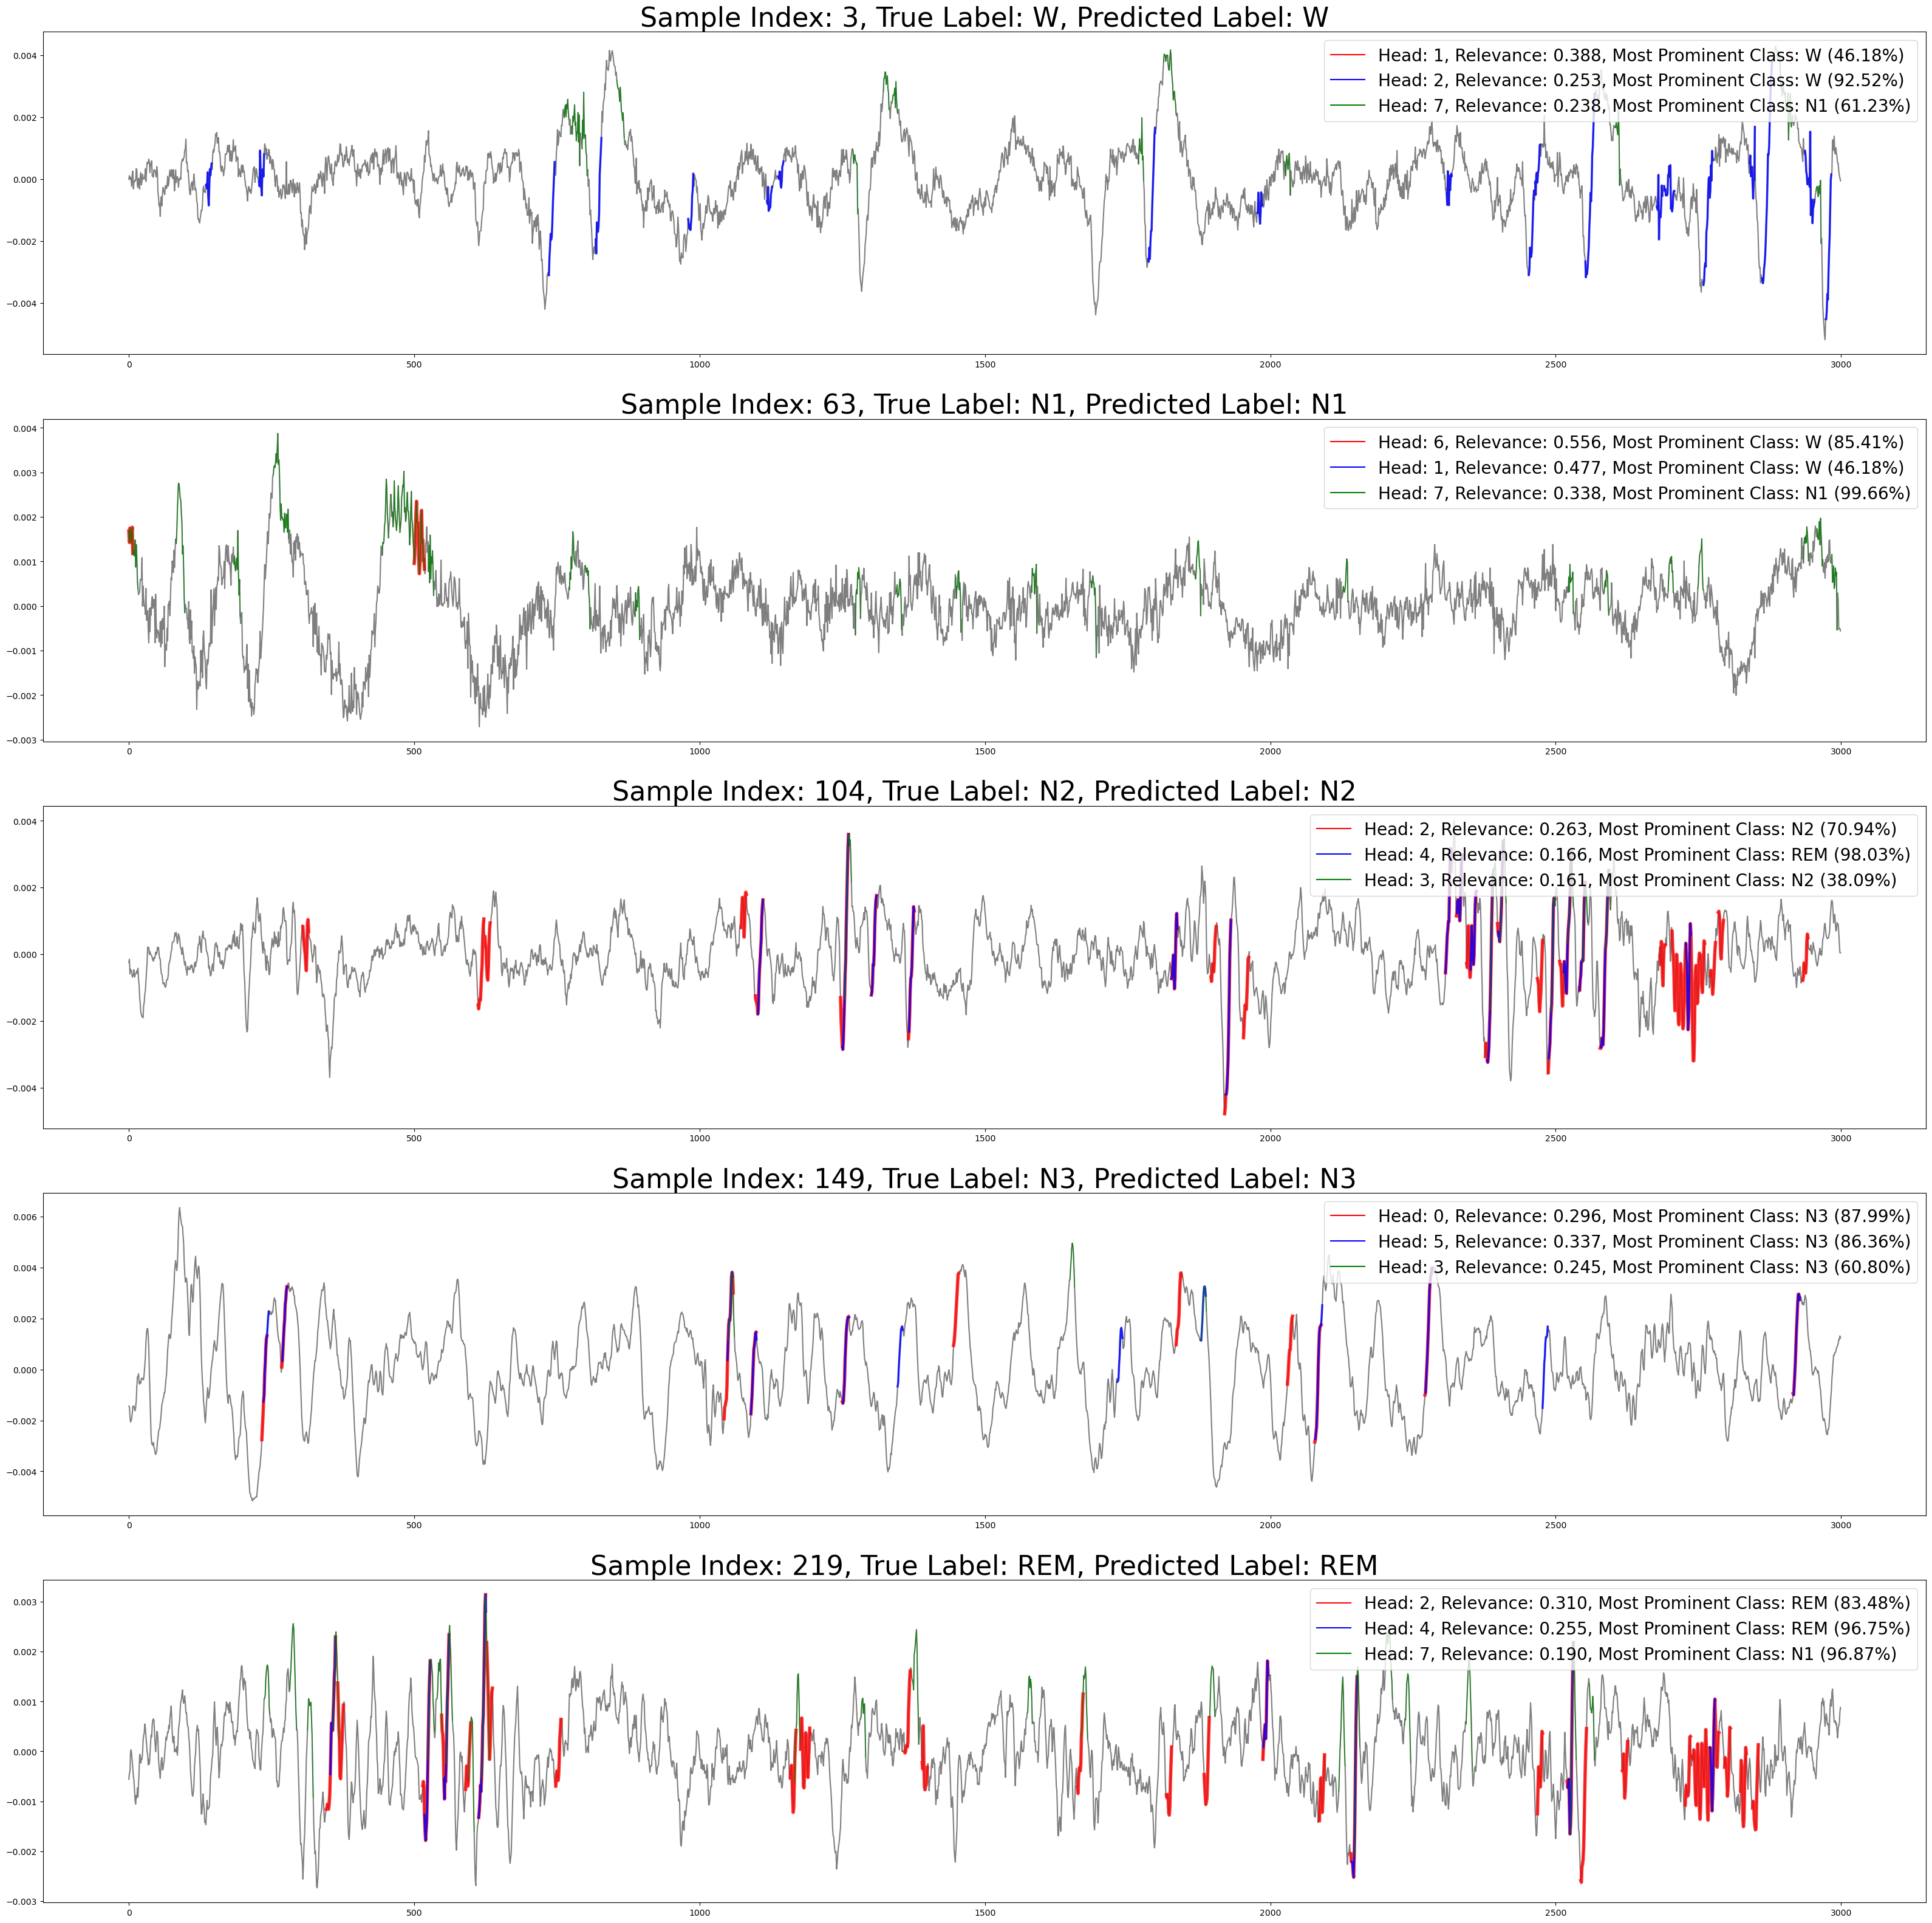

In [26]:
indices = np.array([3, 63, 104, 149, 219])
colours = ['red','blue','green']
linewidths = [4,2.5,1]

times = np.arange(max_len)

n = len(indices)
fig, ax = plt.subplots(len(indices), figsize=(40, 40))

for i, idx in enumerate(indices):

    lines = []
    labels = []

    ax[i].plot(times, x_orig[idx], color='black', alpha=0.5)
    most_relevant_heads = np.flip(np.argpartition(relevance_weights[idx,:], -3)[-3:])
    for j, head in enumerate(most_relevant_heads):
        prototypical_parts = x_orig[idx]*selection[idx, head]
        prototypical_parts[prototypical_parts == 0] = np.nan

        # Overlay non-connected line segments
        ax[i].plot(times, prototypical_parts, color=colours[j], alpha=0.8, linewidth=linewidths[j])
            
        lines.append(Line2D([0],[0], color=colours[j], linestyle='-'))
        labels.append(f"Head: {head}, Relevance: {relevance_weights[idx][head]:0.3f}, Most Prominent Class: {CLASS_DICT[np.argmax(predicted_head[idx, head])]} ({np.max(predicted_head[idx, head]):.2%})")

    ax[i].set_title(
        f"Sample Index: {idx}, True Label: {CLASS_DICT[y_true[idx]]}, Predicted Label: {CLASS_DICT[y_pred[idx]]}",
            fontsize=32
    )

    ax[i].legend(lines, labels, fontsize=20, loc='upper right')

plt.show()

## Spectral Investigation

/var/folders/xh/k3yvbgts22q6kgtr11brfsph0000gn/T/ipykernel_58325/3187675679.py:35: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(


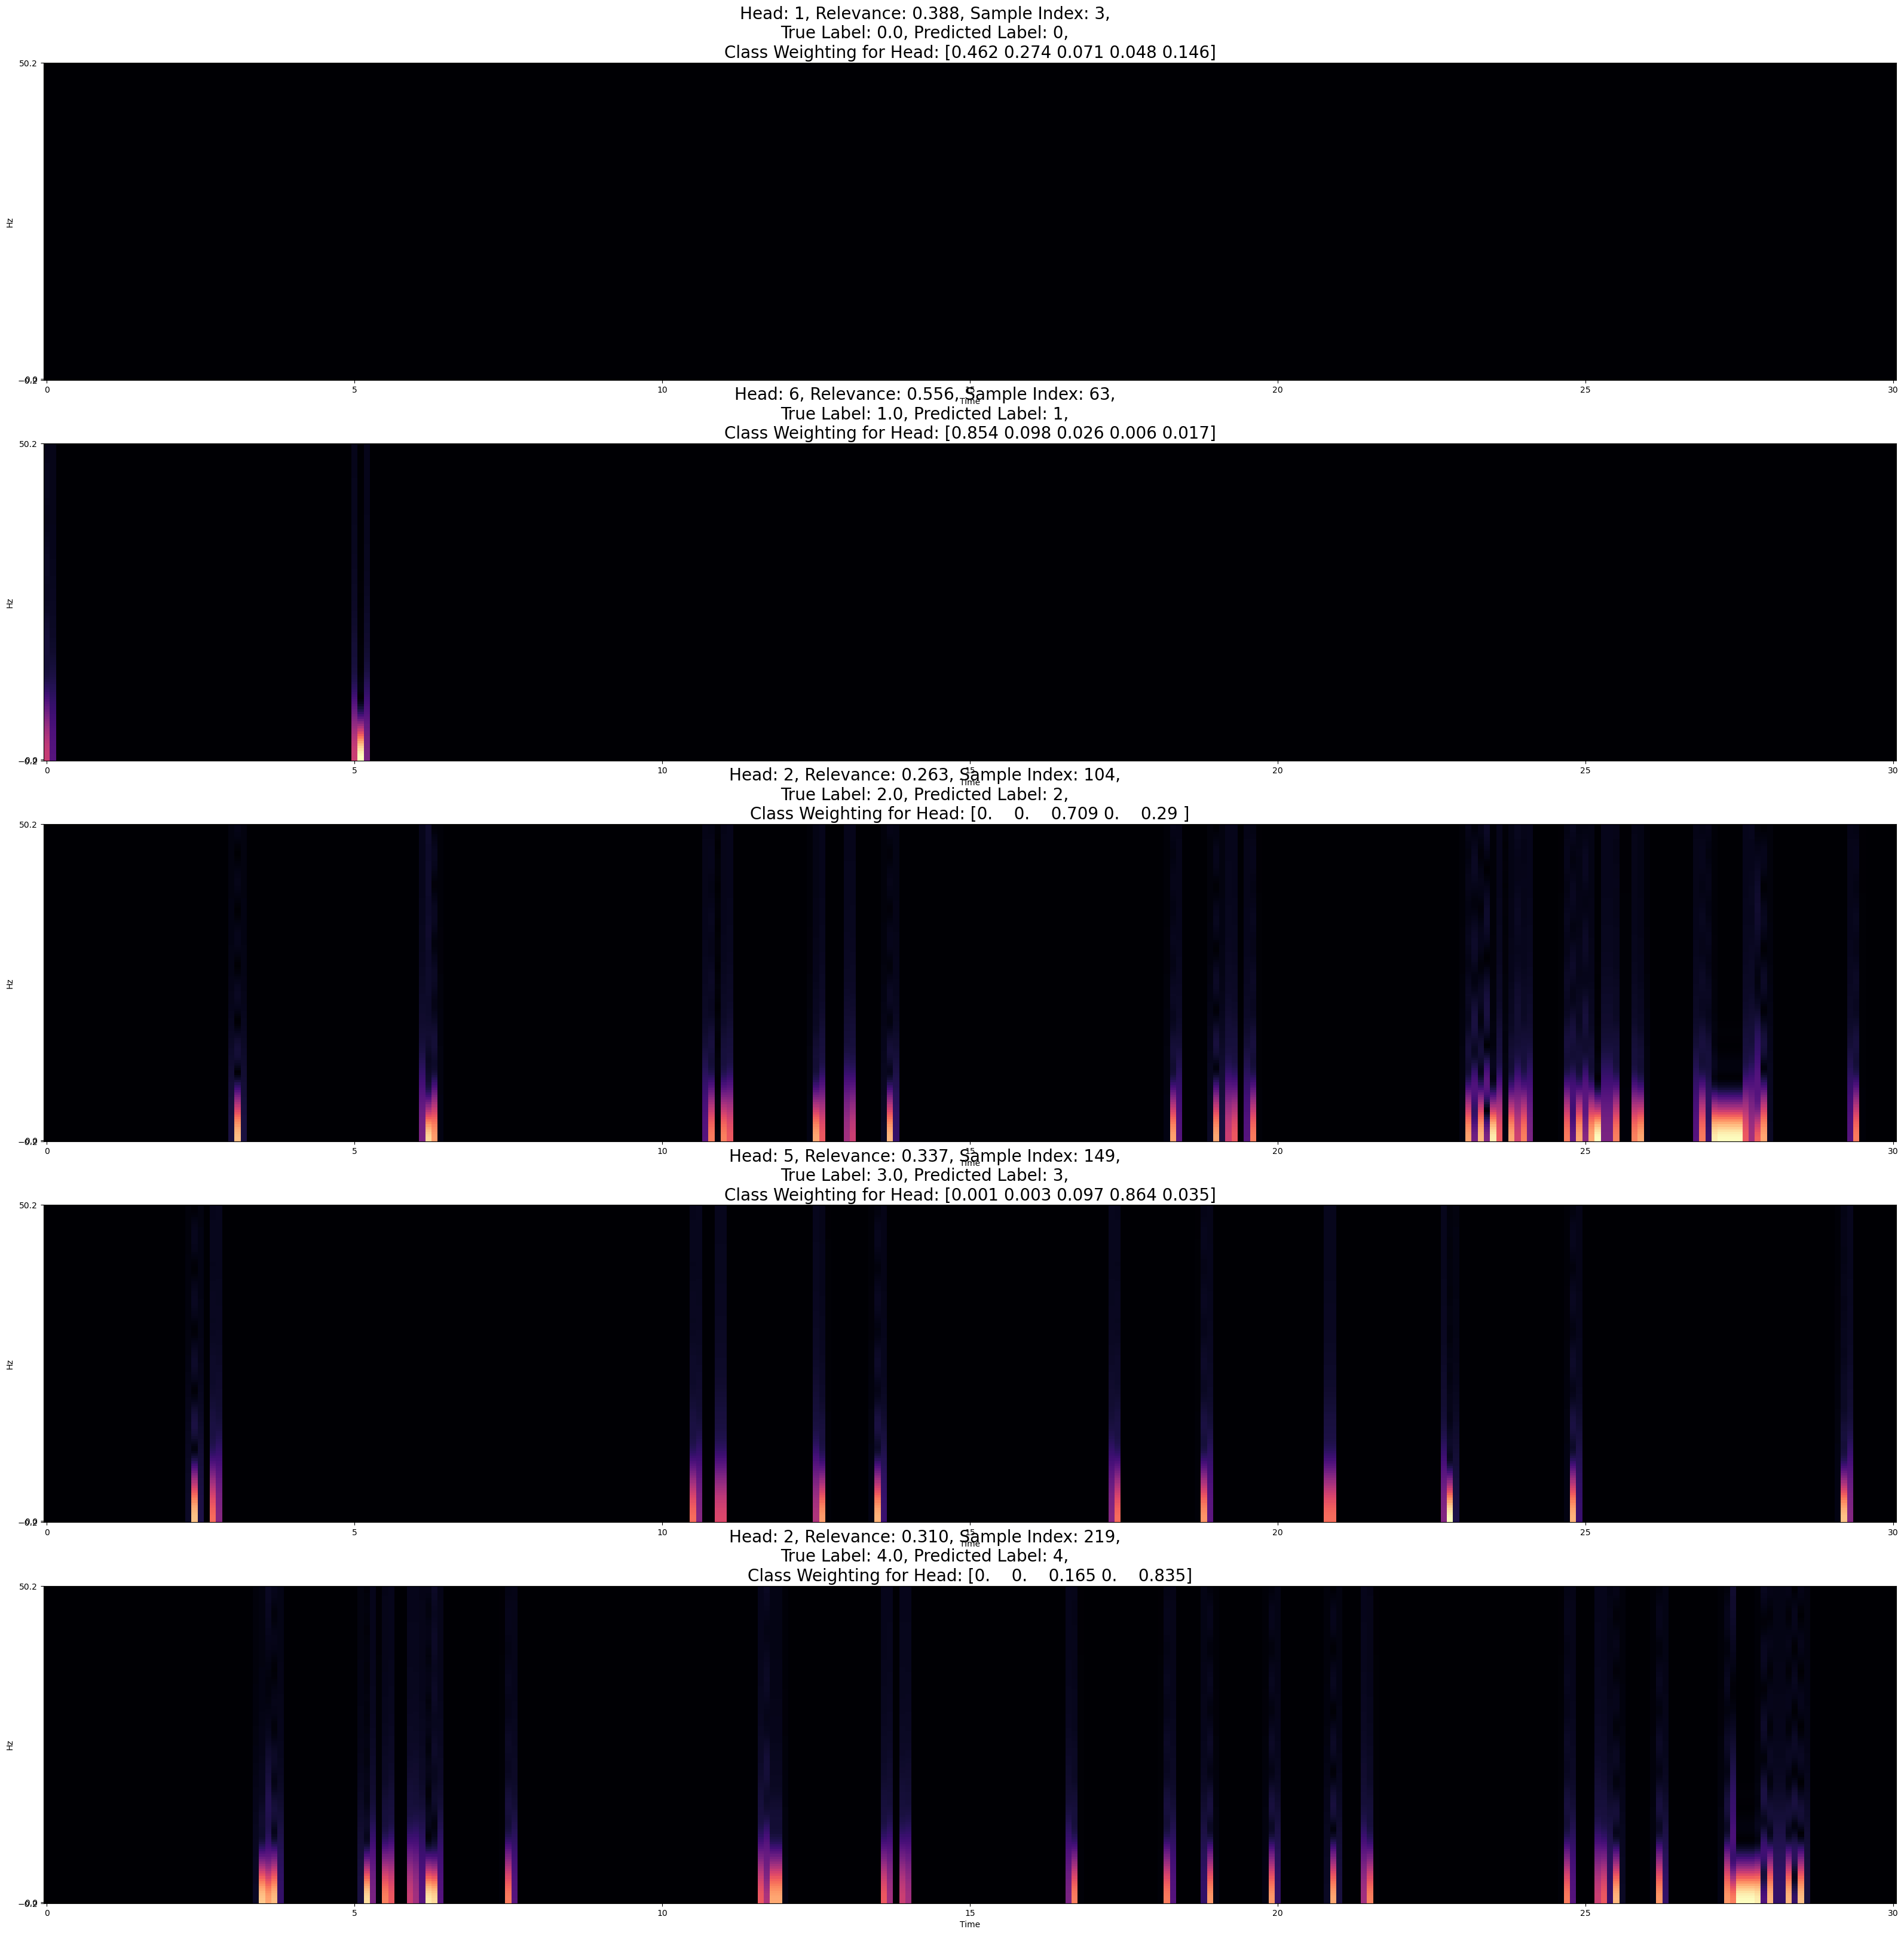

In [120]:
indices = np.array([3, 63, 104, 149, 219])

#range of frequencies of interest for signal.
#It can be any positive value, but should be a power of 2
freq_range = 256
#window size: the number of samples per frame
#each frame is of 20ms (100==100Hz)
win_length = int(100 * 0.2)
#number of samples between two consecutive frames
#by default, hop_length = win_length / 4
hop_length = int(win_length / 2)
#windowing technique
window = 'hann'

n = len(indices)
fig, ax = plt.subplots(len(indices), figsize=(40, 40))

for i, idx in enumerate(indices):

    lines = []
    labels = []

    most_relevant_heads = np.flip(np.argpartition(relevance_weights[idx,:], -1)[-1:])
    for j, head in enumerate(most_relevant_heads):

        spectrogram = librosa.stft(selection[idx, head],
                       n_fft = freq_range,
                       window = window,
                       hop_length = hop_length,
                       win_length = win_length)
        
        librosa.display.specshow(
                        #spectrogram
                        spectrogram,
                        #sampling rate
                        sr = 100,
                        #label for horizontal axis
                        x_axis = 'time',
                        #presentation scale
                        y_axis = 'log',
                        #hop_lenght
                        hop_length = hop_length,
                        ax=ax[i]
                )

        ax[i].set_title(
            f"Head: {head}, Relevance: {relevance_weights[idx][head]:0.3f}, Sample Index: {idx}, \
                \nTrue Label: {y_true[idx]}, Predicted Label: {y_pred[idx]}, \
                \nClass Weighting for Head: {np.around(predicted_head[idx, head], 3)}",
                fontsize=20
        )

plt.show()

/Users/brenton/miniconda3/envs/EEG-SESM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/brenton/miniconda3/envs/EEG-SESM/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/brenton/miniconda3/envs/EEG-SESM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/brenton/miniconda3/envs/EEG-SESM/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/brenton/miniconda3/envs/EEG-SESM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/brenton/miniconda3/envs/EEG-SESM/lib/pyt

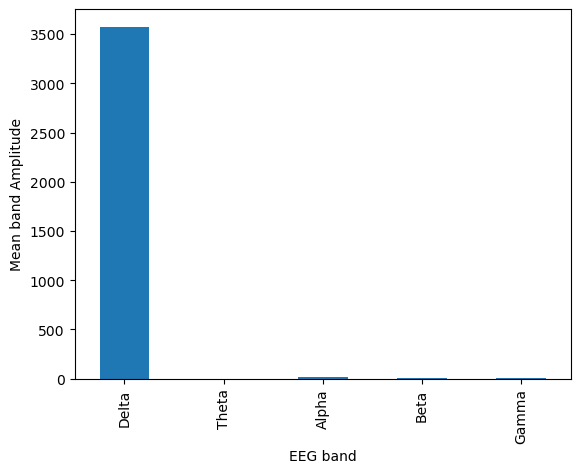

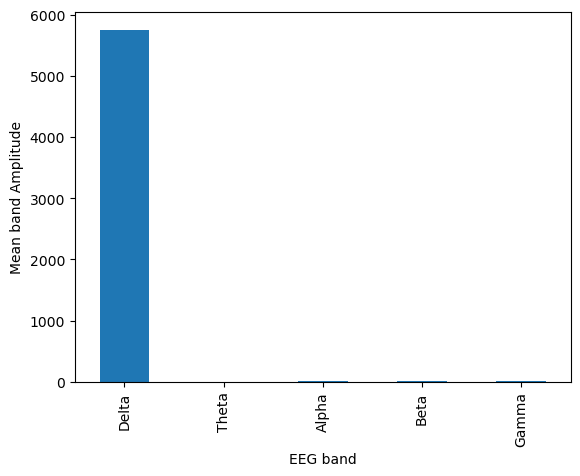

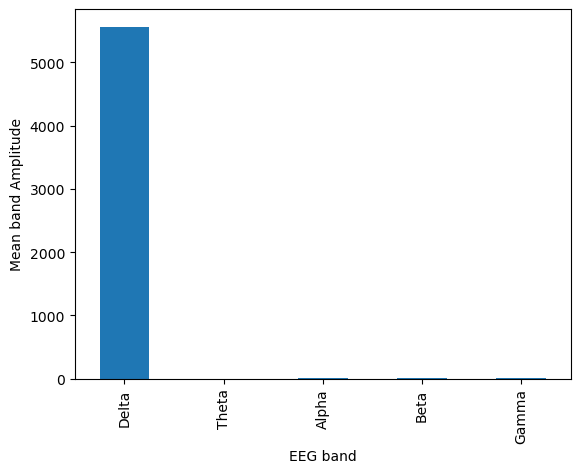

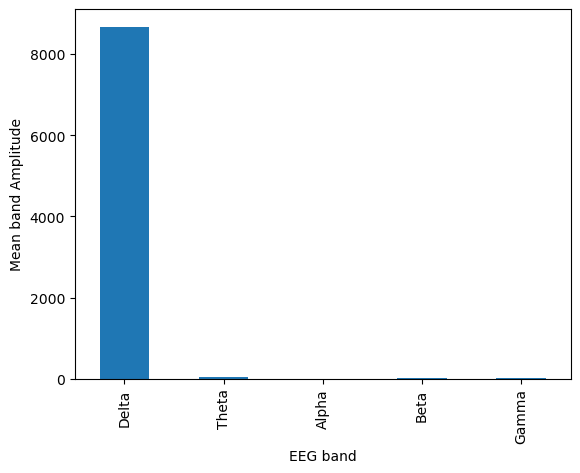

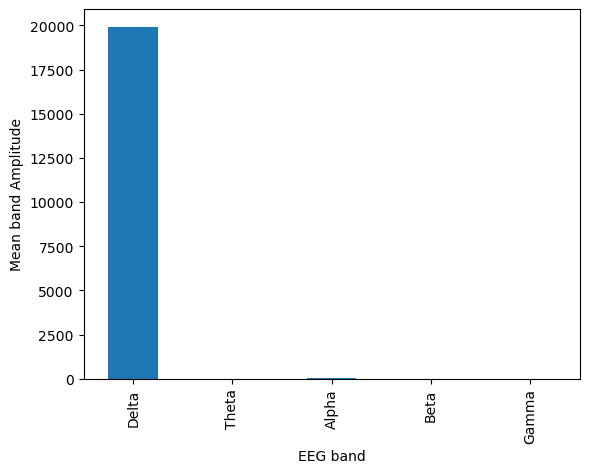

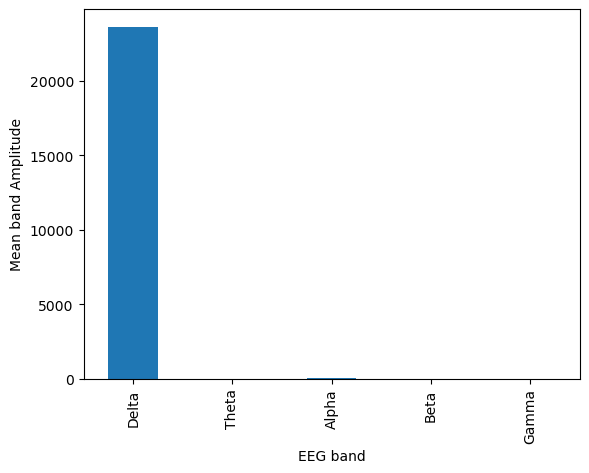

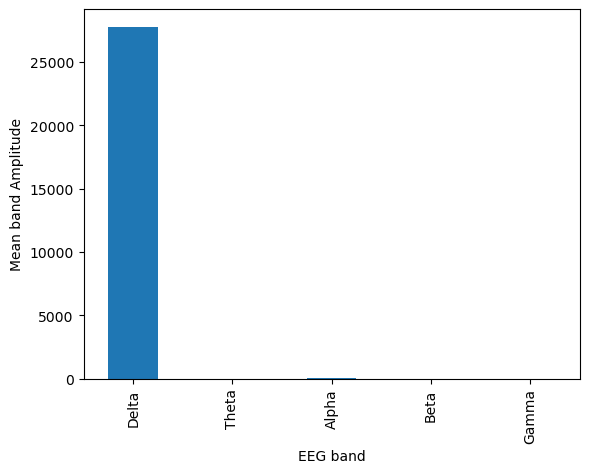

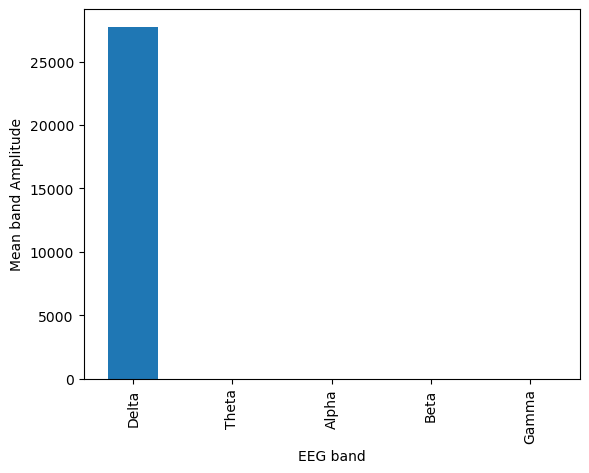

In [28]:
fs = 100
data = selection[219, 4]
nonzero = np.nonzero(data)[0]

 # Create a connect mask
nonzero_diff = np.diff(nonzero, append=0)
threshold = 2
connect_mask = nonzero_diff <= threshold
split_indices = np.where(~connect_mask)[0]
components = np.split(nonzero, split_indices + 1)


for component in components:
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(component))

    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(component), 1.0/fs)

    # Define EEG bands
    eeg_bands = {'Delta': (0, 4),
                'Theta': (4, 8),
                'Alpha': (8, 12),
                'Beta': (12, 30),
                'Gamma': (30, 45)}

    # Take the mean of the fft amplitude for each EEG band
    eeg_band_fft = dict()
    for band in eeg_bands: 
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                        (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])

    # Plot the data (using pandas here cause it's easy)
    import pandas as pd
    df = pd.DataFrame(columns=['band', 'val'])
    df['band'] = eeg_bands.keys()
    df['val'] = [eeg_band_fft[band] for band in eeg_bands]
    ax = df.plot.bar(x='band', y='val', legend=False)
    ax.set_xlabel("EEG band")
    ax.set_ylabel("Mean band Amplitude")

### Investigate spectral features in local neighbourhood of prototypes

[0.02841231 0.03855098 0.02150092 0.0155114  0.01256189 0.00488947
 0.01769771 0.0043168  0.00596398 0.00125659 0.00039098 0.00183743
 0.00276202 0.00156961 0.00061759 0.00130475 0.00128377 0.00334043
 0.00152025 0.00080898 0.00401043 0.00318408 0.00218528 0.0016655
 0.00166238 0.00107235 0.00222958 0.00238163 0.00059144 0.00359834
 0.001142   0.00125925 0.00287213 0.00091445 0.00189935 0.00251646
 0.00259937 0.001262   0.00144798 0.00157843 0.00146507 0.00113778
 0.00098395 0.00066209 0.00049174 0.00147868 0.00223567 0.0003517
 0.00124154 0.00218369 0.00084366 0.00185413 0.00184811 0.00190574
 0.00175397 0.00017538]
[ 0.          0.90909091  1.81818182  2.72727273  3.63636364  4.54545455
  5.45454545  6.36363636  7.27272727  8.18181818  9.09090909 10.
 10.90909091 11.81818182 12.72727273 13.63636364 14.54545455 15.45454545
 16.36363636 17.27272727 18.18181818 19.09090909 20.         20.90909091
 21.81818182 22.72727273 23.63636364 24.54545455 25.45454545 26.36363636
 27.27272727 28.18

Text(0, 0.5, 'Mean band Amplitude')

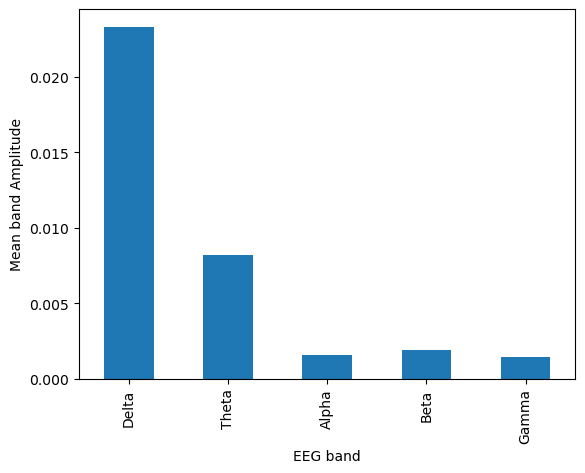

In [128]:
component = x_orig[3, list(range(85,195))]

# Get real amplitudes of FFT (only in postive frequencies)
fft_vals = np.absolute(np.fft.rfft(component))
print(fft_vals)
# Get frequencies for amplitudes in Hz
fft_freq = np.fft.rfftfreq(len(component), 1.0/fs)
print(fft_freq)
# Define EEG bands
eeg_bands = {'Delta': (0, 4),
            'Theta': (4, 8),
            'Alpha': (8, 12),
            'Beta': (12, 30),
            'Gamma': (30, 45)}
# Take the mean of the fft amplitude for each EEG band
eeg_band_fft = dict()
for band in eeg_bands: 
    freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                    (fft_freq <= eeg_bands[band][1]))[0]
    eeg_band_fft[band] = np.mean(fft_vals[freq_ix])
# Plot the data (using pandas here cause it's easy)
import pandas as pd
df = pd.DataFrame(columns=['band', 'val'])
df['band'] = eeg_bands.keys()
df['val'] = [eeg_band_fft[band] for band in eeg_bands]
ax = df.plot.bar(x='band', y='val', legend=False)
ax.set_xlabel("EEG band")
ax.set_ylabel("Mean band Amplitude")

[0.02238923 0.00425021 0.03339021 0.00739098 0.00525816 0.00890901
 0.00623357 0.00557075 0.00485425 0.00577628 0.00271761 0.00330918
 0.00376634 0.00377843 0.00137767 0.002528   0.00461115 0.00280027
 0.00295971 0.00323739 0.00501865 0.0015822  0.00222437 0.0021602
 0.00209414 0.00230739 0.0026192  0.00146409 0.00435831 0.00158066
 0.0039073  0.00415972 0.00554106 0.00483911 0.00112917 0.00115705
 0.00092291 0.00093361 0.00281508 0.0020245  0.00107615 0.00094272
 0.00082905 0.00096733 0.00031754 0.00141588 0.001669   0.00089125
 0.00035634 0.00043198 0.00391601 0.00119305 0.00070173 0.00394338
 0.00236633 0.00304204 0.00073197 0.0026092 ]
[ 0.          0.86956522  1.73913043  2.60869565  3.47826087  4.34782609
  5.2173913   6.08695652  6.95652174  7.82608696  8.69565217  9.56521739
 10.43478261 11.30434783 12.17391304 13.04347826 13.91304348 14.7826087
 15.65217391 16.52173913 17.39130435 18.26086957 19.13043478 20.
 20.86956522 21.73913043 22.60869565 23.47826087 24.34782609 25.21739

Text(0, 0.5, 'Mean band Amplitude')

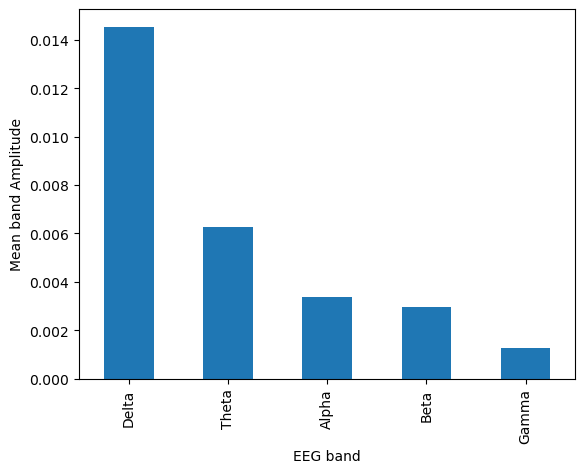

In [137]:
component = x_orig[3, list(range(172,287))]

# Get real amplitudes of FFT (only in postive frequencies)
fft_vals = np.absolute(np.fft.rfft(component))
print(fft_vals)
# Get frequencies for amplitudes in Hz
fft_freq = np.fft.rfftfreq(len(component), 1.0/fs)
print(fft_freq)
# Define EEG bands
eeg_bands = {'Delta': (0, 4),
            'Theta': (4, 8),
            'Alpha': (8, 12),
            'Beta': (12, 30),
            'Gamma': (30, 45)}
# Take the mean of the fft amplitude for each EEG band
eeg_band_fft = dict()
for band in eeg_bands: 
    freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                    (fft_freq <= eeg_bands[band][1]))[0]
    eeg_band_fft[band] = np.mean(fft_vals[freq_ix])
# Plot the data (using pandas here cause it's easy)
import pandas as pd
df = pd.DataFrame(columns=['band', 'val'])
df['band'] = eeg_bands.keys()
df['val'] = [eeg_band_fft[band] for band in eeg_bands]
ax = df.plot.bar(x='band', y='val', legend=False)
ax.set_xlabel("EEG band")
ax.set_ylabel("Mean band Amplitude")

In [130]:
np.nonzero(selection[149, 0])[0]

array([ 233,  234,  235,  236,  237,  238,  239,  240,  241,  242,  268,
        269,  270,  271,  272,  273,  274,  275,  276,  277, 1043, 1044,
       1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055,
       1056, 1057, 1058, 1059, 1090, 1091, 1092, 1093, 1094, 1095, 1096,
       1097, 1098, 1099, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257,
       1258, 1259, 1260, 1261, 1445, 1446, 1447, 1448, 1449, 1450, 1451,
       1452, 1453, 1454, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842,
       1843, 1844, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038,
       2039, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087,
       2088, 2089, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279,
       2280, 2281, 2282, 2283, 2916, 2917, 2918, 2919, 2920, 2921, 2922,
       2923, 2924, 2925, 2926, 2927])

[3.08769212e-02 2.00990557e-01 7.64959667e-02 5.64446679e-02
 1.00863234e-02 1.13622500e-02 3.06933593e-02 4.70458732e-03
 1.03644534e-02 7.49442774e-03 5.28422388e-03 8.41735105e-04
 5.34881187e-03 1.42498893e-03 4.94847979e-03 2.45435005e-03
 3.07131727e-03 4.15980006e-03 1.94392378e-03 3.11753822e-03
 2.53590315e-03 2.60590835e-03 3.68370016e-03 1.24351778e-03
 2.21831470e-03 2.36104035e-03 1.53069160e-03 1.41003507e-03
 8.50200369e-04 1.58388873e-03 9.79737151e-04 1.17236377e-03
 1.85533876e-03 1.33867742e-03 1.57788139e-03 1.06341422e-03
 1.21406945e-03 1.83604292e-03 5.28971259e-04 1.75363855e-03
 1.24948932e-03 1.30418658e-03 6.40852191e-04 1.83293560e-03
 1.16797967e-03 4.64362018e-05 8.85543730e-04 2.85175930e-04
 1.16098702e-04 1.17439842e-03 1.12147831e-03 1.50542315e-04
 1.38515369e-03 5.37866463e-04 8.27847151e-04 1.16307569e-03]
[ 0.          0.90909091  1.81818182  2.72727273  3.63636364  4.54545455
  5.45454545  6.36363636  7.27272727  8.18181818  9.09090909 10.
 10.909

Text(0, 0.5, 'Mean band Amplitude')

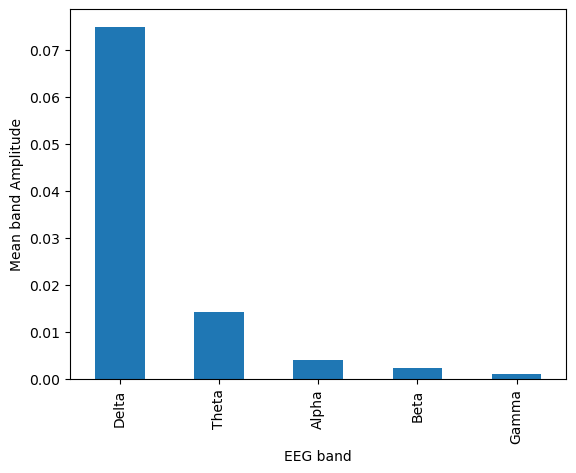

In [138]:
component = x_orig[149, list(range(200,310))]

# Get real amplitudes of FFT (only in postive frequencies)
fft_vals = np.absolute(np.fft.rfft(component))
print(fft_vals)
# Get frequencies for amplitudes in Hz
fft_freq = np.fft.rfftfreq(len(component), 1.0/fs)
print(fft_freq)
# Define EEG bands
eeg_bands = {'Delta': (0, 4),
            'Theta': (4, 8),
            'Alpha': (8, 12),
            'Beta': (12, 30),
            'Gamma': (30, 45)}
# Take the mean of the fft amplitude for each EEG band
eeg_band_fft = dict()
for band in eeg_bands: 
    freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                    (fft_freq <= eeg_bands[band][1]))[0]
    eeg_band_fft[band] = np.mean(fft_vals[freq_ix])
# Plot the data (using pandas here cause it's easy)
import pandas as pd
df = pd.DataFrame(columns=['band', 'val'])
df['band'] = eeg_bands.keys()
df['val'] = [eeg_band_fft[band] for band in eeg_bands]
ax = df.plot.bar(x='band', y='val', legend=False)
ax.set_xlabel("EEG band")
ax.set_ylabel("Mean band Amplitude")

## Sleep feature analysis of prototypes

In [36]:
# indices = np.array([3, 63, 104, 149, 219])
colours = ['red', 'blue','green', 'orange']
linewidths = [4,3,2,1]

def make_sleep_feature_plot(index):
    idx = index

    fig, axes = plt.subplots(2)
    fig.set_size_inches(16,9)

    # Plot features
    data = x_orig[idx]*100000
    sf = 100
    times = np.arange(data.size) / sf

    sw = sw_detect(data, sf=sf, dur_neg=(0.1,1.5), dur_pos=(0.1,1))
    sw_mask = sw.get_mask()
    events = sw.summary()
    events.round(2)

    sw_highlight = data * sw_mask
    sw_highlight[sw_highlight == 0] = np.nan

    sp = spindles_detect(data, sf=sf, duration=(0.1, 3))
    if sp is not None:
        sp_mask = sp.get_mask()
    else:
        sp_mask = np.zeros(data.shape)

    spindles_highlight = data * sp_mask
    spindles_highlight[spindles_highlight == 0] = np.nan

    axes[0].plot(times, data, color='black', alpha=0.5)
    axes[0].plot(events['NegPeak'], sw_highlight[(events['NegPeak'] * sf).astype(int)], 'bo', label='SW Negative peaks')
    axes[0].plot(events['PosPeak'], sw_highlight[(events['PosPeak'] * sf).astype(int)], 'go', label='SW Positive peaks')
    axes[0].plot(events['Start'], data[(events['Start'] * sf).astype(int)], 'ro', label='SW Start')
    axes[0].plot(times, sw_highlight, 'orange', label='Slow Waves')
    axes[0].plot(times, spindles_highlight, 'darkcyan', label='Spindles')

    axes[0].set_title('Estimated features')
    axes[0].legend(
        loc='upper right',
        ncols=2,
        bbox_to_anchor=(1, 1.3),
        prop={'size': 10},
        fancybox=True, shadow=True
    )
    axes[0].set_xlabel('Time (seconds)')
    axes[0].set_ylabel('Amplitude (uV)')
    axes[0].set_xlim([0, times[-1]])

    # Plot heads
    lines = []
    labels = []

    axes[1].plot(times, data, color='black', alpha=0.5)
    most_relevant_heads = np.flip(np.argpartition(relevance_weights[idx,:], -4)[-4:])
    for j, head in enumerate(most_relevant_heads):
        prototypical_parts = x_orig[idx]*selection[idx, head]
        prototypical_parts[prototypical_parts == 0] = np.nan

        # Overlay non-connected line segments
        axes[1].plot(times, prototypical_parts*100000, color=colours[j], alpha=0.8, linewidth=linewidths[j])
            
        lines.append(Line2D([0],[0], color=colours[j], linestyle='-'))
        labels.append(f"Head: {head}, Relevance: {relevance_weights[idx][head]:0.3f}, Most Prominent Class: {CLASS_DICT[np.argmax(predicted_head[idx, head])]} ({np.max(predicted_head[idx, head]):.2%})")

    axes[1].set_title('Most relevant heads')
    axes[1].legend(
        lines,
        labels,
        loc='upper right',
        bbox_to_anchor=(1, 1.38),
        prop={'size': 10},
        fancybox=True, shadow=True
    )
    axes[1].set_xlabel('Time (seconds)')
    axes[1].set_ylabel('Amplitude (uV)')
    axes[1].set_xlim([0, times[-1]])


    fig.suptitle(
        f"Sample Index: {idx}, True Label: {CLASS_DICT[y_true[idx]]}, Predicted Label: {CLASS_DICT[y_pred[idx]]}"
    )

    plt.tight_layout()
    plt.show()


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
22-Jan-24 20:19:26 | WARNING | No spindle were found in channel CHAN000.
22-Jan-24 20:19:26 | WARNING | No spindles were found in data. Returning None.


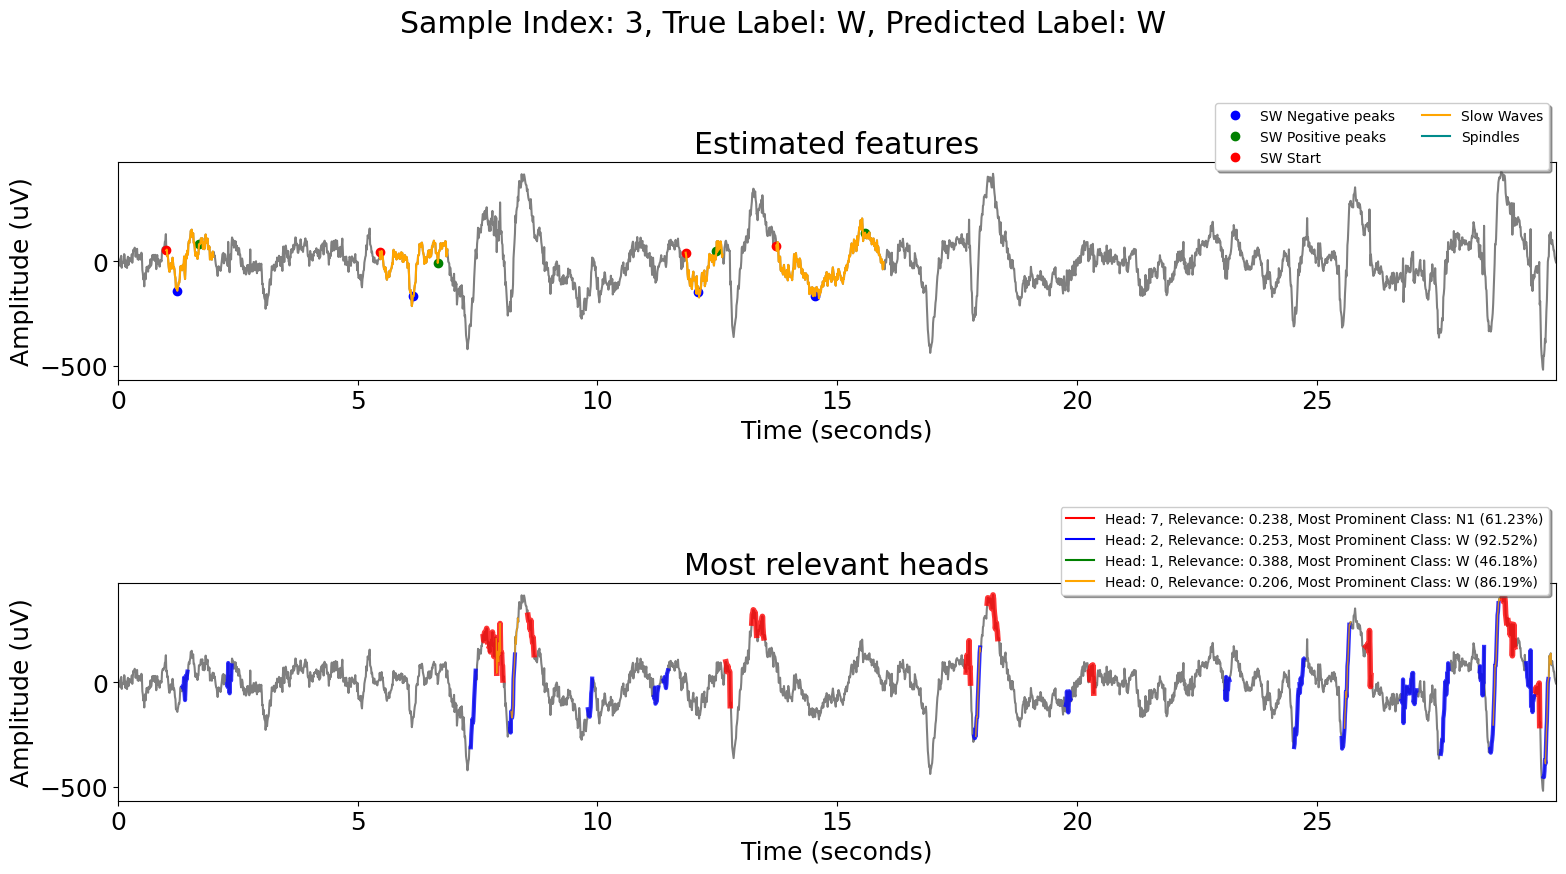

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


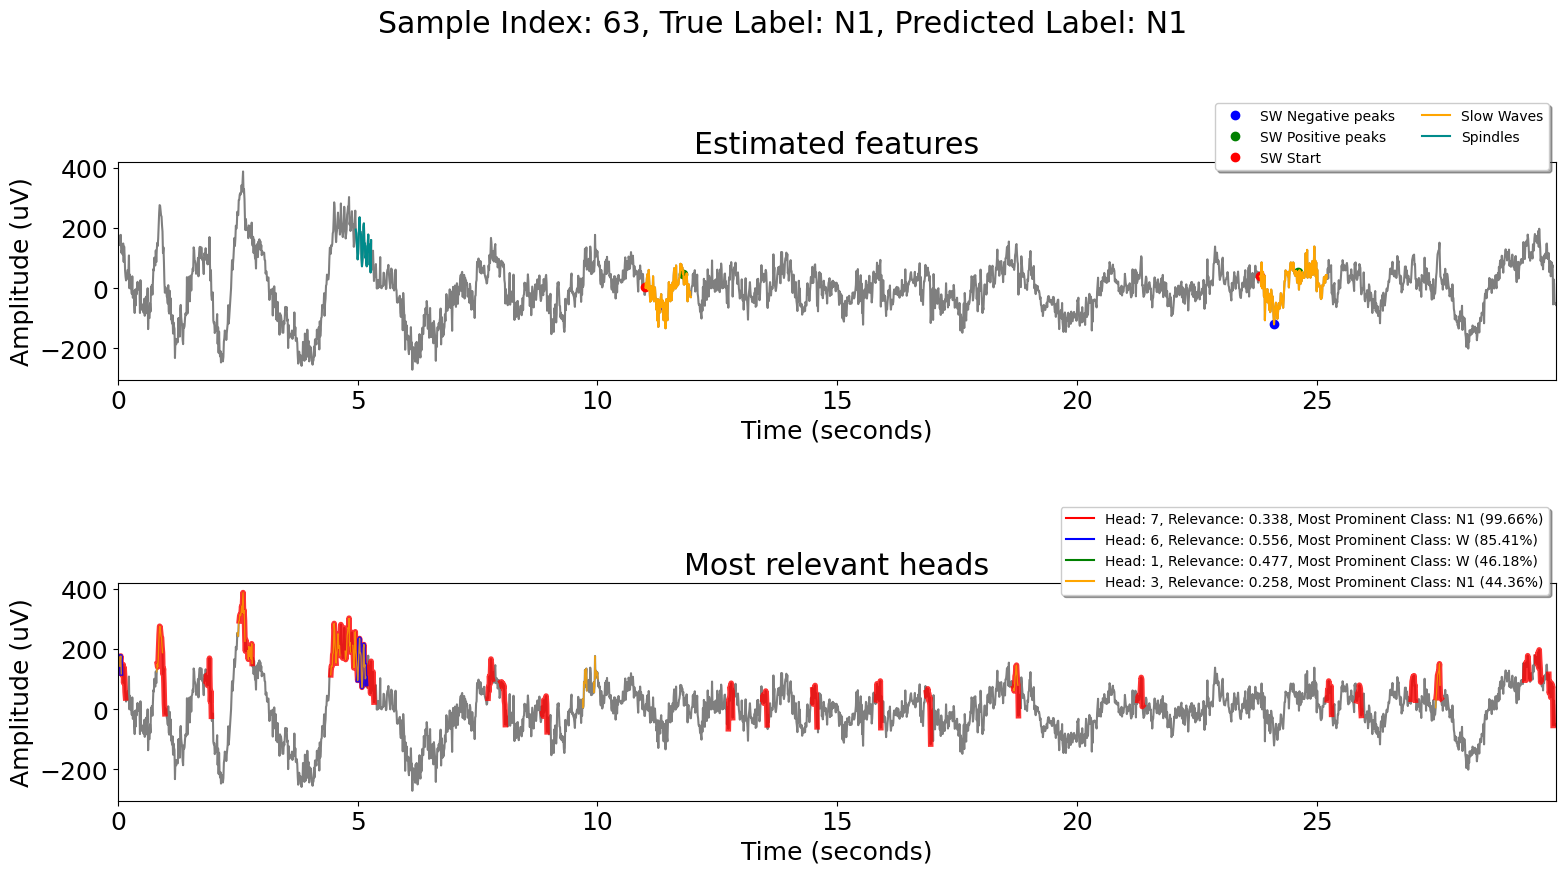

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


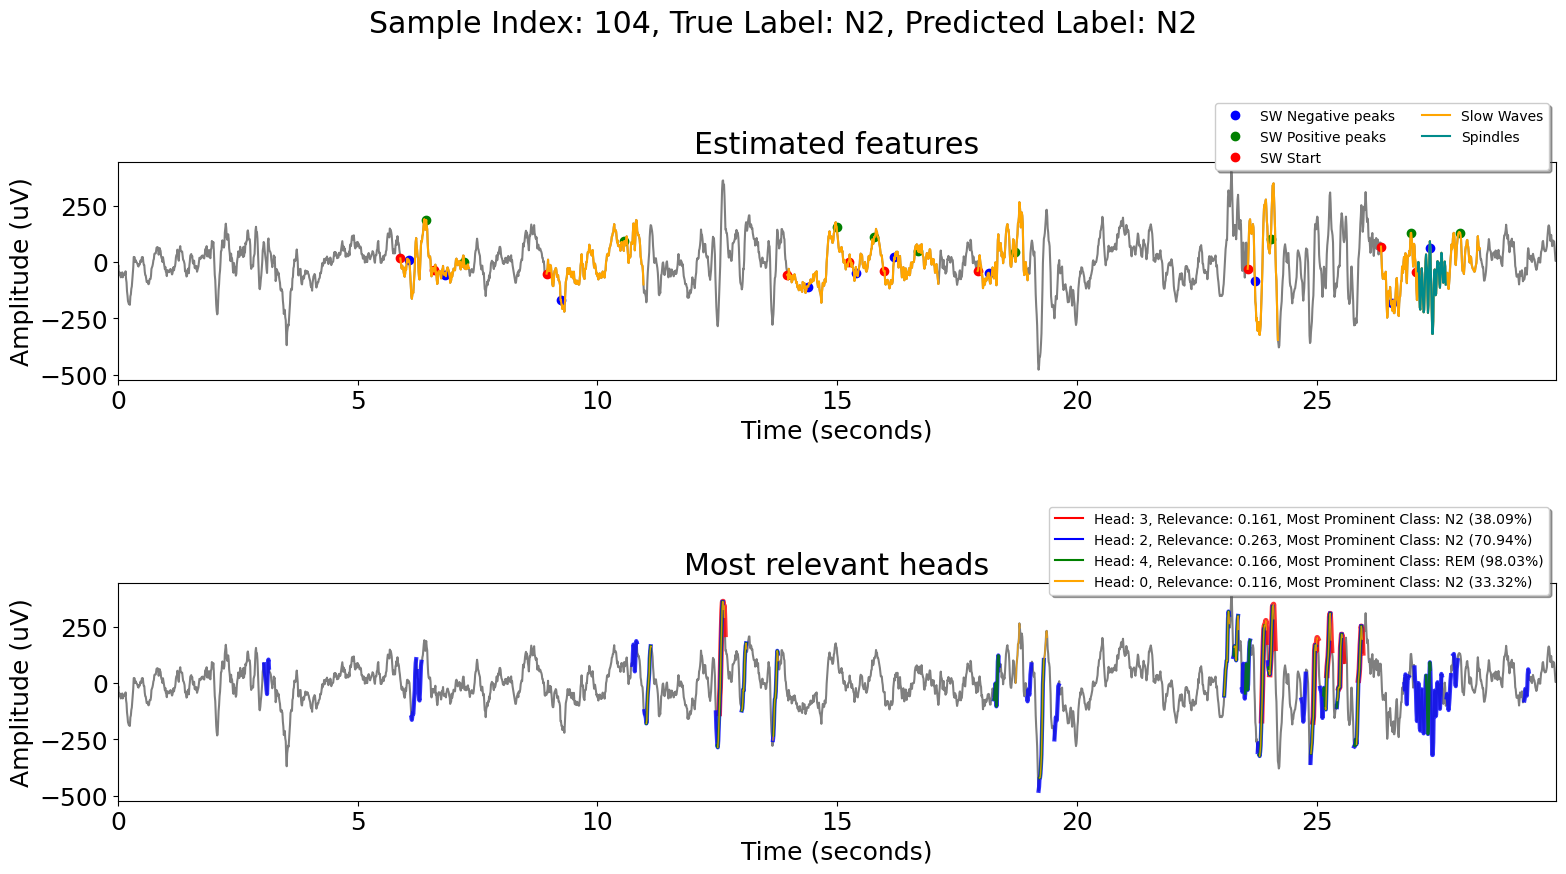

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
22-Jan-24 20:19:27 | WARNING | No spindle were found in channel CHAN000.
22-Jan-24 20:19:27 | WARNING | No spindles were found in data. Returning None.


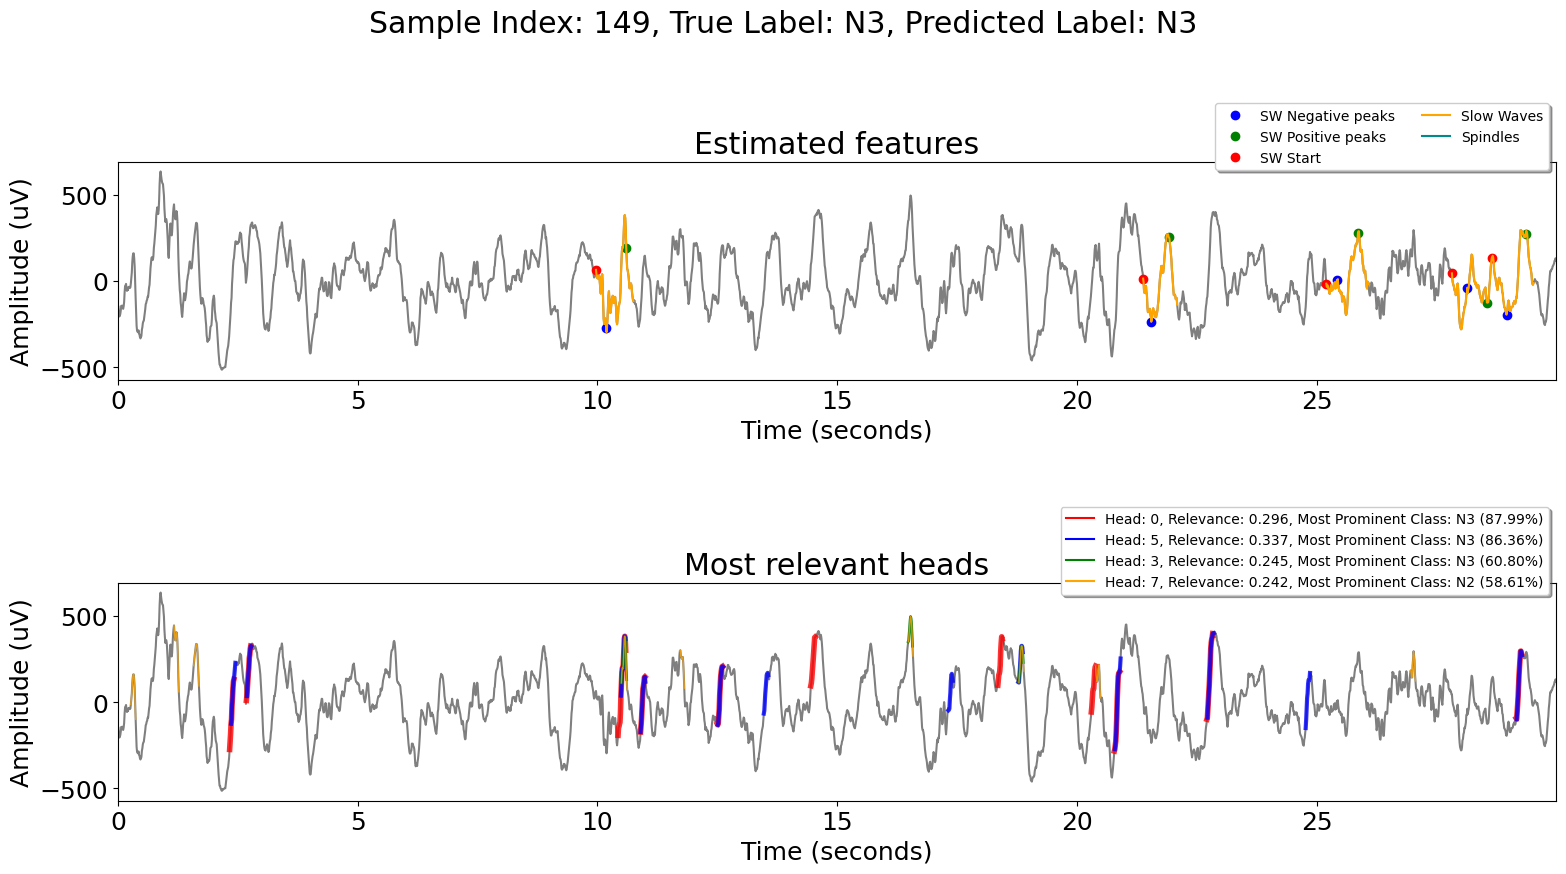

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


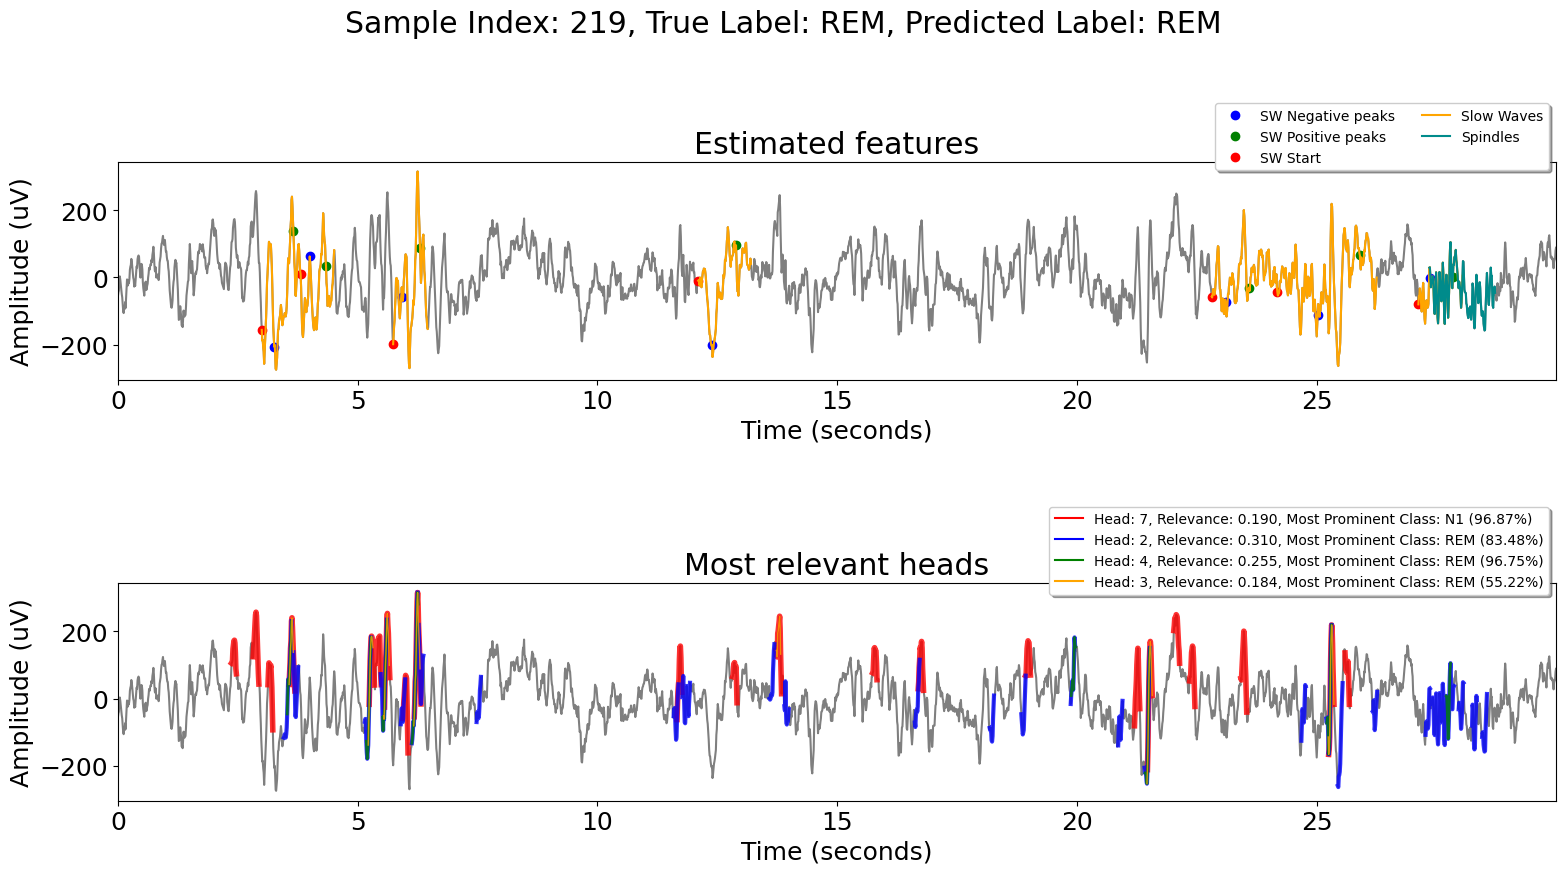

In [37]:
indices = np.array([3, 63, 104, 149, 219])

for index in indices:
    make_sleep_feature_plot(index)